In [1]:
import datetime
import sys
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from configuredEstimator import confRegressorEstimator

tf.logging.set_verbosity(tf.logging.INFO)

sys.path.append("/jup/projects/mtgtools2/")  # ensure we find the MTG libraries
import pymtg.fci.esl.training_data as esl
import pymtg

MNT_DIR = Path("/scratch/andreu/")
RETINAS_JSON = Path(pymtg.__file__).parent.parent / "test/FCI_ESL/pyesl/config/retinas.json"
ESL_PATH = MNT_DIR / "ESL/nc/output/20170615T152646/ch123/"
FCI_PATH = MNT_DIR / "ESL/nc/swaths/"

def collapse_scene(scene, step=1):
    col_scene = scene[0]
    for s in scene[1:]:
        col_scene = np.insert(col_scene, -step, s.transpose()[-step], axis=1)  # create single input scene.
    return col_scene

def plot_scene(scene):
    plt.imshow(collapse_scene(scene))
    plt.title('Input scene')
    plt.show()

def plot_esl(esl):
    plt.imshow(esl)
    plt.title('ESL')
    plt.show()
    
def get_model_name(name='Unnamed_conf_model'):
    d = datetime.datetime.now()
    return "{}_{}".format(name, d.strftime("%Y%m%dT%H%M%S"))
                          
def get_model_dir(model_dir, **kwargs):
    return "{}/{}".format(model_dir, get_model_name(**kwargs))
                          
def input_fn(size, train_or_test='train', collapsed=False, num_batches=1, mode=tf.estimator.ModeKeys.TRAIN, plot_data=False):
    """
    Input function that serves data to the estimator.
    If not collapsed it will return x={features:(size, 129, 186), y=(size, 113). num_batches will be ignored
    If collapsed, it will return x={features:(num_batches, 129, 186+size)}, y=(num_batches, 113xsize)
    The argument train_or_test should be set to train for the moment, as test is not validated.
    """
    files = esl.prepare_training_data(FCI_PATH, ESL_PATH, 0, str(RETINAS_JSON))
    out_batch = list(files[train_or_test].batches("ch123", size, 20000, num_batches=num_batches))  # use always 'train', 'test' is not validated
    if collapsed:
        features = np.array([collapse_scene(out_batch[i][0]) for i in range(num_batches)])
        labels = np.array([out_batch[i][1].flatten() for i in range(num_batches)])
    else:
        features = out_batch[0][0]  # only one batch
        labels = out_batch[0][1]    
    if plot_data:  # for validation purposes during prediction, will plot only the first image
        if collapsed:
            for f in features:
                plt.imshow(f)
                plt.show()
            for l in labels:
                plt.imshow(l.reshape(out_batch[0][1].shape))
                plt.show()
        else:
            plot_scene(features)
            plot_esl(out_batch[0][1])    
    dataset = tf.data.Dataset.from_tensors(({'features': features}, labels))
    return dataset

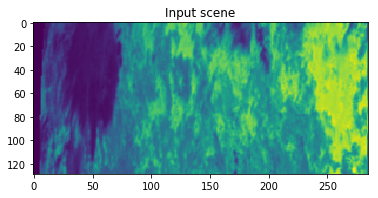

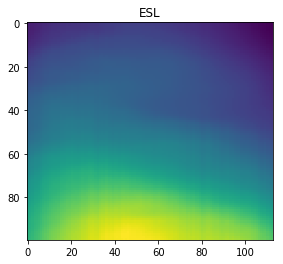

<TensorDataset shapes: ({features: (100, 129, 186)}, (100, 113)), types: ({features: tf.float64}, tf.float64)>

In [2]:
input_fn(100, num_batches=2, plot_data=True, collapsed=False)

In [5]:
from functools import partial

SIZE = 100
TRAIN_STEPS = 100
TEST_STEPS=10
MODEL = 'FC_config.yml'
NUM_BATCHES = 100
COLLAPSED = False

# config
run_config = tf.estimator.RunConfig(model_dir=get_model_dir("/mnt/data/tensorboard", name=MODEL),
                                    save_checkpoints_steps=100,
                                    keep_checkpoint_max = 5)
                        
# create the estimator
esl_regressor = confRegressorEstimator(MODEL, config=run_config)
                                       
train_spec = tf.estimator.TrainSpec(input_fn=partial(input_fn, size=SIZE, num_batches=NUM_BATCHES, collapsed=COLLAPSED), 
                                    max_steps=TRAIN_STEPS)
eval_spec = tf.estimator.EvalSpec(input_fn=partial(input_fn, size=SIZE, num_batches=NUM_BATCHES, collapsed=COLLAPSED),
                                  steps=TEST_STEPS)

tf.estimator.train_and_evaluate(esl_regressor, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': '/mnt/data/tensorboard/FC_config.yml_20180706T130829', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcdc8d70f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorfl

In [ ]:
# single evaluation
foo = esl_regressor.evaluate(input_fn=partial(input_fn, size=SIZE, num_batches=1, collapsed=COLLAPSED, plot_data=False))

In [ ]:
foo = esl_regressor.predict(input_fn=partial(input_fn, size=SIZE, num_batches=1, collapsed=COLLAPSED, plot_data=True))
pred_esl = np.array([p['predictions'] for p in foo])

plt.imshow(pred_esl.reshape((SIZE, 113)))
plt.title('Retrieved ESL')
plt.show()